In [29]:
import requests
import config
import json
from pprint import pprint
import matplotlib.pyplot as plt
import pandas as pd

In [30]:
base_url='https://www.bootcampspot.com/api/instructor/v1'
login={"email": config.email,
       "password": config.password}

### login

In [31]:
response=requests.post(base_url+'/login', json=login)
response_json=response.json()
auth_token=response_json['authenticationInfo']['authToken']

### me

In [32]:
headers={'Content-Type': 'application/json', 'authToken': auth_token}
response=requests.get(base_url+'/me', headers=headers)
response_json=response.json()
# display(pprint(response_json))
courses=response_json['Enrollments']
# print('Available Courses: ')
# for each_course in courses: 
#     print(each_course['course']['name'])

In [33]:
def get_enrollmentId_courseId(course):
    for each_course in courses: 
        if each_course['course']['name']==course: 
            return (each_course['id'], each_course['courseId'])
    return (None, None)
enrollmentId, courseId=get_enrollmentId_courseId('DU-DEN-DATA-PT-12-2020-U-C-TTH')
# enrollmentId, courseId=get_enrollmentId_courseId('DU-DEN-DATA-PT-08-2020-U-C-MW')

### grades

In [34]:
headers={'Content-Type': 'application/json', 'authToken': auth_token}
payload={'courseId': courseId}
response=requests.post(base_url+'/grades', headers=headers, json=payload)
response_json=response.json()
grades_df=pd.DataFrame(response_json)

### assignments

In [35]:
headers={'Content-Type': 'application/json', 'authToken': auth_token}
payload={'enrollmentId': enrollmentId}
response=requests.post(base_url+'/assignments', headers=headers, json=payload)
response_json=response.json()
current_week_assignments=response_json['currentWeekAssignments']
calendar_assignments=response_json['calendarAssignments']
required_assignments=[each_assignment for each_assignment in calendar_assignments if each_assignment['required']==True]
required_assignments_df=pd.DataFrame(required_assignments)
# required_assignments_df.head()

### assignment_details

In [36]:
# assignmentId=int(required_assignments_df['id'][0])
# assignmentId

In [37]:
headers={'Content-Type': 'application/json', 'authToken': auth_token}
data=[]

for idx, each_assignment in required_assignments_df['id'].iteritems(): 
#     print(each_assignment)
    payload={'assignmentId': int(each_assignment)}
    response=requests.post(base_url+'/assignmentDetail', headers=headers, json=payload)

    response_json=response.json()
    assignment=response_json['assignment']
    students=response_json['students']
    
    for each_student in students: 
        assignment_dict={}
        good_record=False
        try: 
            assignment_dict['assignment_due_date']=assignment['dueDate']
            assignment_dict['assignment_header']=assignment['assignmentHeader']['header']
            assignment_dict['assignment_number']=assignment['assignmentHeader']['header'].split('.')[0]
            assignment_dict['student']=each_student['student']['firstName']+' '+each_student['student']['lastName']
            assignment_dict['submission_date']=each_student['submission']['date']
            assignment_dict['grade']=each_student['grade']['grade']
            assignment_dict['grade_date']=each_student['grade']['date']
            good_record=True
        except: 
            pass
#             print(f"No submission for {each_student['student']['firstName']} for {assignment['assignmentHeader']['header']}")
        if good_record: 
                  data.append(assignment_dict)

assignment_detail_df=pd.DataFrame(data)
# assignment_detail_df.head()

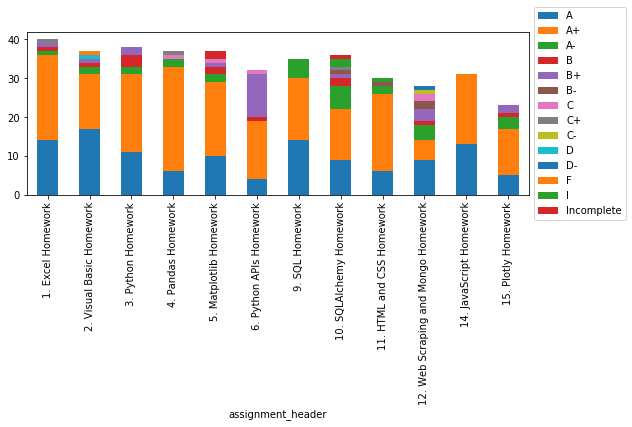

In [70]:
assignment_detail_df=assignment_detail_df.loc[assignment_detail_df['assignment_number'].str.isnumeric()]
assignment_grades=assignment_detail_df.pivot_table(index='assignment_header', columns='grade', aggfunc='size')
assignment_grades.sort_index(key=lambda x: x.str.split('.').str[0].astype(int)).plot(kind='bar', stacked=True, legend=None, figsize=(9, 3))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [14]:
# assignment_detail_df[assignment_detail_df['assignment_header']=='11. HTML and CSS Homework']['student']

In [15]:
# pd.DataFrame(assignment_detail_df.groupby('student').size(), columns=['Count']).sort_values(by='Count')

In [16]:
# assignment_detail_df['grade_date']=pd.to_datetime(assignment_detail_df['grade_date'])

In [17]:
# assignment_detail_df

In [18]:
assignment_detail_df['grade'].value_counts()

A+            217
A             175
A-             29
B+             22
B              13
C               5
I               4
B-              4
C+              3
Incomplete      3
C-              1
D               1
F               1
D-              1
Name: grade, dtype: int64

In [20]:
# df['grade'].value_counts()